In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import datetime
#from datetime import datetime
from sklearn.metrics import mean_squared_error,accuracy_score,r2_score
from sklearn.model_selection import train_test_split

datetime64[ns]
           Symbol     Open     High      Low    Close Percent Change  \
Date                                                                   
2023-01-24  NEPSE  2166.05  2173.24  2139.89  2173.25           0.38   
2023-01-23  NEPSE  2184.77  2203.13  2162.83  2165.10          -0.63   
2023-01-19  NEPSE  2175.30  2192.71  2163.14  2178.81           0.26   
2023-01-18  NEPSE  2185.73  2214.78  2166.35  2173.10          -0.41   
2023-01-17  NEPSE  2152.05  2187.79  2136.38  2182.11           1.52   

                  Volume   Prev_Volume  
Date                                    
2023-01-24  3.003230e+09  3.864009e+09  
2023-01-23  3.864009e+09  3.044529e+09  
2023-01-19  3.044529e+09  4.928715e+09  
2023-01-18  4.928715e+09  3.724795e+09  
2023-01-17  3.724795e+09  5.477625e+09  


,Close,Prev_Volume
Date,,
2023-01-24,2173.25,3.864009e+09
2023-01-23,2165.10,3.044529e+09
2023-01-19,2178.81,4.928715e+09
2023-01-18,2173.10,3.724795e+09
2023-01-17,2182.11,5.477625e+09


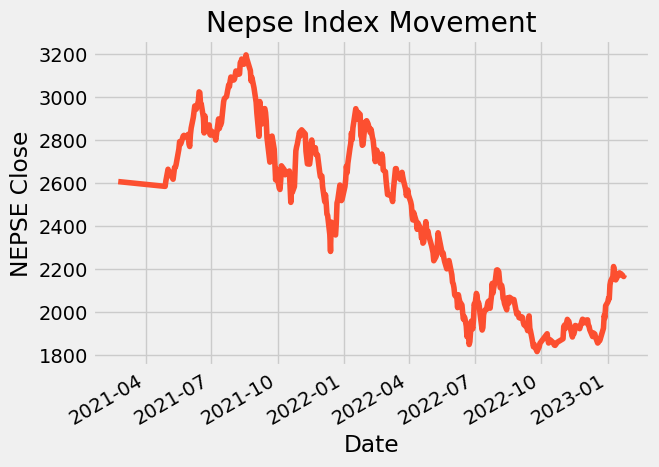

In [18]:
s = 8
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
df = pd.read_excel('NEPSE.xlsx',parse_dates=True,skiprows=0,index_col='Date')
print(df.index.dtype)
df['Prev_Volume'] = df['Volume'].shift(-1)
df.replace(0,np.nan,inplace=True)
df=df.dropna()
print(df.head())
df = df[['Close','Prev_Volume']]
fig,ax =plt.subplots()
df['Close'].plot(color = color_pal[1],ax=ax)
plt.title('Nepse Index Movement')
plt.ylabel('NEPSE Close')
df.head()

In [3]:
def create_features(df):
    df=df.copy()
    df['year']=df.index.year
    df['day_of_week']=df.index.dayofweek
    df['quarter']=df.index.quarter
    df['day']=df.index.day
    df['month']=df.index.month
    return df

                Close  Prev_Volume      year  day_of_week   quarter       day  \
Close        1.000000     0.776471 -0.681700     0.007405 -0.250844 -0.021123   
Prev_Volume  0.776471     1.000000 -0.587080    -0.033496 -0.130413 -0.020234   
year        -0.681700    -0.587080  1.000000    -0.004847 -0.378428 -0.037642   
day_of_week  0.007405    -0.033496 -0.004847     1.000000 -0.003676 -0.010261   
quarter     -0.250844    -0.130413 -0.378428    -0.003676  1.000000  0.024781   
day         -0.021123    -0.020234 -0.037642    -0.010261  0.024781  1.000000   
month       -0.259193    -0.116935 -0.401515    -0.007850  0.969565  0.026917   

                month  
Close       -0.259193  
Prev_Volume -0.116935  
year        -0.401515  
day_of_week -0.007850  
quarter      0.969565  
day          0.026917  
month        1.000000  


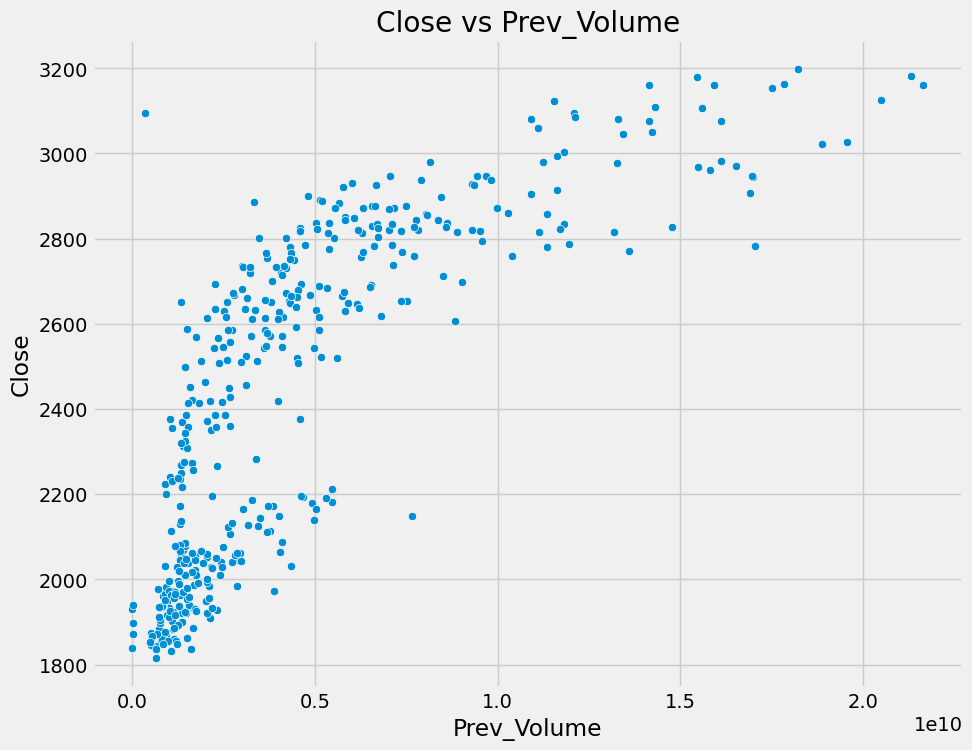

In [4]:
df_n = create_features(df)
fig,ax =plt.subplots(figsize=(10,8))
print(df_n.corr())
sns.scatterplot(data=df_n,x='Prev_Volume',y='Close')
ax.set_title('Close vs Prev_Volume')
plt.show()

In [5]:
X=df_n.drop('Close',axis=1)
print(X.head())
y=df_n['Close']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=s)

             Prev_Volume  year  day_of_week  quarter  day  month
Date                                                            
2023-01-24  3.864009e+09  2023            1        1   24      1
2023-01-23  3.044529e+09  2023            0        1   23      1
2023-01-19  4.928715e+09  2023            3        1   19      1
2023-01-18  3.724795e+09  2023            2        1   18      1
2023-01-17  5.477625e+09  2023            1        1   17      1


[19:15:53] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "early_stoping_rounds", "n_estimator" } are not used.

The score for XGBoost is 0.9334131486986479
The score for RandomForest is 0.9130499255769069


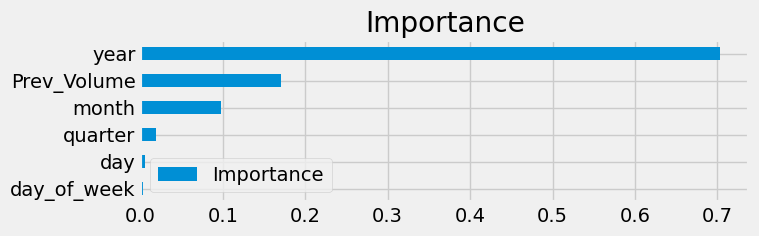

In [6]:
reg_XGB=xgb.XGBRegressor(n_estimator=1000,early_stoping_rounds=50,random_state=s)
reg_RF=RandomForestRegressor(random_state=s)
reg_XGB.fit(X_train,y_train)
reg_RF.fit(X_train,y_train)
y_pred_xgb=reg_XGB.predict(X_test)
y_pred_RF=reg_RF.predict(X_test)
print('The score for XGBoost is {}'.format(reg_XGB.score(X_test,y_test)))
print('The score for RandomForest is {}'.format(reg_RF.score(X_test,y_test)))
d=pd.DataFrame(index=reg_XGB.feature_names_in_,data=reg_XGB.feature_importances_,columns=['Importance']).sort_values('Importance')
d.plot(kind='barh',figsize=(7,2))
plt.title('Importance')
plt.show()


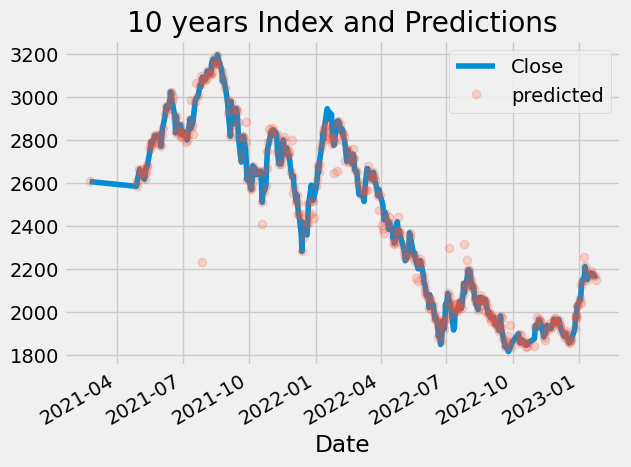

In [7]:
df_n['prediction']=reg_XGB.predict(X)
fig,ax = plt.subplots()
df_n['Close'].plot(ax=ax)
df_n['prediction'].plot(style='o',ax=ax,alpha=0.2,label='predicted')
plt.legend()
plt.title('10 years Index and Predictions')
plt.show()

In [19]:
print(reg_XGB.predict(pd.DataFrame({"Prev_Volume":[3.003230e+09],"year":[2023],"day_of_week":[2],"quarter":[1],"day":[25],"month":[1]})))

[2231.2578]
